In [561]:
## Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import linalg
from scipy.special import legendre,spherical_jn
import scipy.integrate as integrate
from numpy import math
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

In [562]:
# Parameter Setting
# c is the Bandwidth
# n is the order
# N is the order of approximation
N=24
c=4

In [563]:
## Function to generate PSWF on finite domain
def Prolate_Gen(c, n):
    N=24    #Approximant order
    T0=1
    A=[[0 for x in range(N)] for y in range(N)]
    for i in range(N):
        for j in range(N):
            if(i==j):
                k=i
                A[i][j]=k*(k+1)+(c*c)*(((2*k*(k+1))-1)/((2*k+3)*(2*k-1)))
            if(j==i+2):
                k=i
                A[i][j]=((k+1)*(k+2)*c*c)/((2*k+3)*np.sqrt((2*k+1)*(2*k+5)))
            if(i==j+2):
                k=j
                A[i][j]=((k+1)*(k+2)*c*c)/((2*k+3)*np.sqrt((2*k+1)*(2*k+5)))
    ## B is the eigen vector
    chi,beta=linalg.eig(A)
    idx=np.argsort(chi)
    chi=chi[idx]
    beta=beta[:,idx]
    ## s1 is the polynomial
    s1=0
    for i in range(N):        
        s1=s1+np.poly1d(beta[i][n]*np.sqrt(i+0.5)*legendre(i))

    psi1=[]
    ax=[]
    for i in range(2000*T0):
        psi1.append(s1(-T0+(i/1000)))
        ax.append(-T0+(i/1000))
    ## Visualizing the PSFW of the given order
    plt.plot(ax,psi1,label='Order = '+str(n))
    plt.title("PSFW of order 1 to 5 for bandwidth c="+str(c))
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    return s1,beta

In [564]:
#This computes eigenvalues only for even orders
def Eigen_finder(s1):
    pi=3.141592
    x0=0.1
    f1=lambda x:s1(x)*((np.sin((c)*(x-x0))/(pi*(x-x0))))
    f2=lambda x:s1(x)*((c)/pi)
    I1=integrate.quad(f1,-1,x0-0.0001)[0]
    I2=integrate.quad(f2,x0-0.0001,x0+0.0001)[0]
    I3=integrate.quad(f1,x0+0.0001,1)[0]
    eig_n=(I1+I2+I3)/s1(x0)
    return eig_n

In [565]:
def Orthogonal(s1,s2,eig_n1,eig_n2,beta1,beta2,m,n,tspan):
    N=24
    d0n1=[]
    d0n2=[]
    for i in range(N):
        d0n1.append(beta1[i][m]*np.sqrt(i+0.5))
        d0n2.append(beta2[i][n]*np.sqrt(i+0.5))
    Norm1=0
    Norm2=0
    for i in range(N):
        Norm1=Norm1+(1/(2*i+1))*d0n1[i]*d0n1[i]
        Norm2=Norm2+(1/(2*i+1))*d0n2[i]*d0n2[i]
    Norm1=2*Norm1
    Norm2=2*Norm2
    f=lambda x:np.sqrt(eig_n1/Norm1)*np.sqrt(eig_n2/Norm2)*s1(x)*s2(x)
    x=integrate.quad(f,-1*tspan,tspan)[0]
    return x

In [566]:
def Infinte_Domain_PSWF(c,n,eig_n,beta):
    pi=np.pi
    d0n=[]
    for i in range(N):
        d0n.append(beta[i][n]*np.sqrt(i+0.5))
    Norm=0
    for i in range(N):
        if n%2==0 and i%2==0:
            Norm=Norm+(1/(2*i+1))*d0n[i]*d0n[i]
        elif n%2!=0 and i%2!=0:
            Norm=Norm+(1/(2*i+1))*d0n[i]*d0n[i]
        else:
            continue
    Norm=2*Norm
    if n%2==0:
        lambda_n=(2*c/pi)*((((d0n[0]*(2**n)*(math.factorial(n/2)**2)))/(math.factorial(n)))**2)
    else:
        lambda_n=(2*c/pi)*(((c*d0n[1]*(2**n)*math.factorial((n-1)/2)*math.factorial((n+1)/2))/(math.factorial(n+1)*3))**2)
    kn=0
    #print(lambda_n)
    if n%2==0:
        kn=math.factorial(n)*(1/(d0n[0]*(2**n)*(math.factorial(n/2)**2)))
    else:
        kn=3*math.factorial(n+1)*(1/(c*d0n[1]*(2**n)*math.factorial((n-1)/2)*math.factorial((n+1)/2)))
    tspan=10
    Psi_inf1=[]
    J=[]
    j=0
    i=0
    for i in range(2000*tspan):
        j=(i/1000)-tspan
        sum=0
        for z in range(N):
            if z%2==0 and n%2==0:
                sum=sum+d0n[z]*spherical_jn(z,abs(c*j))*((-1)**((z-n)/2))
            elif z%2!=0 and n%2!=0:
                sum=sum+d0n[z]*spherical_jn(z,abs(c*j))*((-1)**((z-n)/2))
            else:
                continue
        if j<0 and n%2!=0:
            Psi_inf1.append(-sum*kn*np.sqrt(lambda_n/Norm))          #not normalized by np.sqrt(eig_n/Norm)
        elif j>0 and n%2!=0:
            Psi_inf1.append(sum*kn*np.sqrt(lambda_n/Norm))
        else:
            Psi_inf1.append(sum*kn*np.sqrt(lambda_n/Norm))
        J.append(j)
    plt.plot(J,Psi_inf1,label="order = "+str(n))
    plt.legend()
    return Psi_inf1,J

In [567]:
def coeff(poly):
    coeff0=lambda x:np.sinc(x)*poly(x)
    I=integrate.quad(coeff0,-1,1)[0]
    return I

In [568]:

def coeff_inf(Psi_inf,J):
    product=[]
    for i in range(len(J)):
          product.append(Psi_inf[i]*np.sinc(J[i]))
    return np.trapz(product,J)


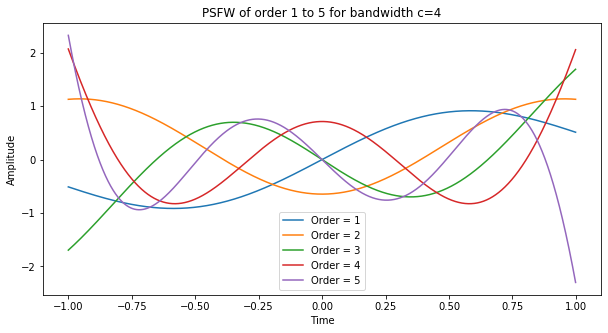

In [569]:
## Visualizing PSWFs of differnet Order and Bandwidths
s1,beta1=Prolate_Gen(c,1)
s2,beta2=Prolate_Gen(c,2)
s3,beta3=Prolate_Gen(c,3)
s4,beta4=Prolate_Gen(c,4)
s5,beta5=Prolate_Gen(c,5)
## Bandwidth, Order
## PSF in [-1,-1] of the given bandwidth and order

In [570]:
# Compute eigenvalues of PSWF
print("The Eignen Values for the given c and different orders are: ")
eig_n1=Eigen_finder(s1)
print(eig_n1)
eig_n2=Eigen_finder(s2)
print(eig_n2)
eig_n3=Eigen_finder(s3)
print(eig_n3)
eig_n4=Eigen_finder(s4)
print(eig_n4)
eig_n5=Eigen_finder(s5)
print(eig_n5)

The Eignen Values for the given c and different orders are: 
0.9121076138258897
0.519054945442891
0.1102110099458153
0.008827878236543725
0.00038129180331396723


In [571]:
# Change the parameter tspan to toggle between finite and infinite modes
tspan = 1000 
lis = []
s = {1: s1, 2: s2, 3: s3, 4: s4, 5: s5}
eig = {1: eig_n1, 2: eig_n2, 3: eig_n3, 4: eig_n4, 5: eig_n5}
beta = {1: beta1, 2: beta2, 3: beta3, 4: beta4, 5: beta5}
for i in range(1,6):
    for j in range(1,6):
        lis.append(round(Orthogonal(s[i],s[j],eig[i],eig[j],beta[i],beta[j],i,j,tspan),5))
lis = np.reshape(lis, (5, 5)).T
print("Orthonormality for c = "+str(c)+"\n")
print(lis)

Orthonormality for c = 4

[[ 3.38392681e+119  0.00000000e+000 -8.91951026e+119  0.00000000e+000
  -8.55847456e+119]
 [ 0.00000000e+000  4.89573063e+115  0.00000000e+000 -6.75521687e+115
   0.00000000e+000]
 [-8.91951026e+119  0.00000000e+000  2.35104563e+120  0.00000000e+000
   2.25588217e+120]
 [ 0.00000000e+000 -6.75521687e+115  0.00000000e+000  9.32096931e+115
   0.00000000e+000]
 [-8.55847456e+119  0.00000000e+000  2.25588217e+120  0.00000000e+000
   2.16457066e+120]]


Text(0, 0.5, 'Time')

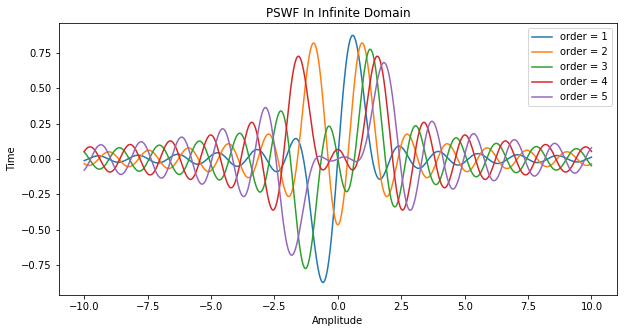

In [572]:
## Visualing PSWFs in Infinite Domain
Psi_inf1,J=Infinte_Domain_PSWF(c,1,eig_n1,beta1)
Psi_inf21,J=Infinte_Domain_PSWF(c,2,eig_n2,beta2)
Psi_inf3,J=Infinte_Domain_PSWF(c,3,eig_n3,beta3)
Psi_inf4,J=Infinte_Domain_PSWF(c,4,eig_n4,beta4)
Psi_inf5,J=Infinte_Domain_PSWF(c,5,eig_n5,beta5)
plt.title("PSWF In Infinite Domain")
plt.xlabel("Amplitude")
plt.ylabel("Time")

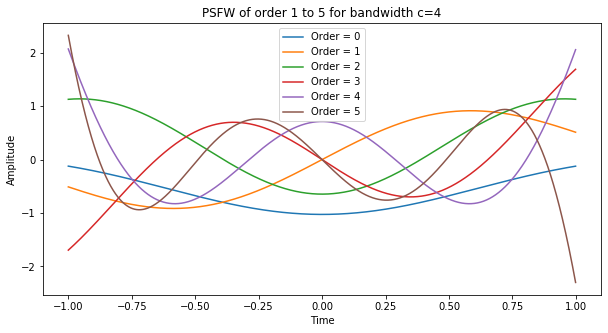

In [573]:
## Coefficients for Finite Support Reconstruction
p0,b0=Prolate_Gen(c,0)
p1,b1=Prolate_Gen(c,1)
p2,b2=Prolate_Gen(c,2)
p3,b3=Prolate_Gen(c,3)
p4,b4=Prolate_Gen(c,4)
p5,b5=Prolate_Gen(c,5)

In [574]:
I0=coeff(p0)
I1=coeff(p1)
I2=coeff(p2)
I3=coeff(p3)
I4=coeff(p4)
I5=coeff(p5)

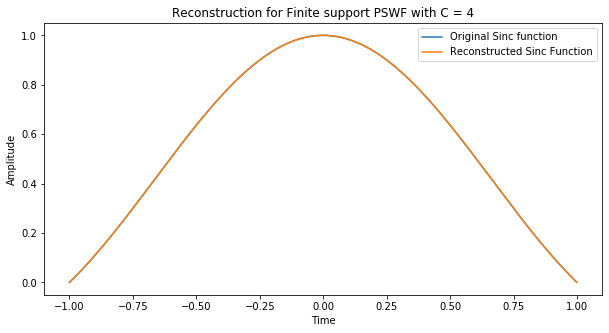

In [575]:
x=[]
sinc_org=[]
sinc_reconstr=[]
for i in range(2000):
    x.append(-1+(i/1000))
    sinc_org.append(np.sinc(-1+(i/1000)))
    sinc_reconstr.append(I0*p0(-1+(i/1000))+I1*p1(-1+(i/1000))+I2*p2(-1+(i/1000))+I3*p3(-1+(i/1000))+I4*p4(-1+(i/1000)))
plt.plot(x,sinc_org, label= "Original Sinc function")
plt.plot(x,sinc_reconstr, label= "Reconstructed Sinc Function")
plt.title("Reconstruction for Finite support PSWF with C = "+str(c))
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

In [576]:
## Energy Loss in Finite Domain
k=(np.sum(np.array(sinc_org)**2)-np.sum(np.array(sinc_reconstr)**2))/np.sum(np.array(sinc_org)**2)*100
print(k)

4.49835277827625e-07


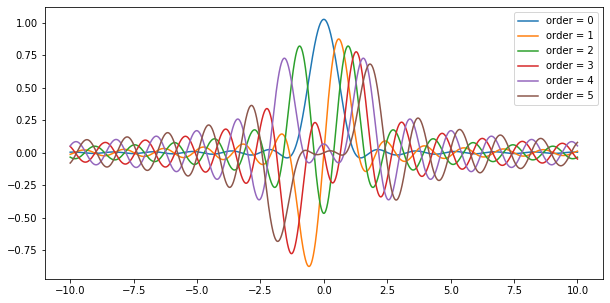

In [577]:
## Coefficients for Infinite support
eig_n0=Eigen_finder(p0)
eig_n1=Eigen_finder(p1)
eig_n2=Eigen_finder(p2)
eig_n3=Eigen_finder(p3)
eig_n4=Eigen_finder(p4)
eig_n5=Eigen_finder(p5)

Psi_inf0,J=Infinte_Domain_PSWF(c,0,eig_n0,b0)
Psi_inf1,J=Infinte_Domain_PSWF(c,1,eig_n1,b1)
Psi_inf2,J=Infinte_Domain_PSWF(c,2,eig_n2,b2)
Psi_inf3,J=Infinte_Domain_PSWF(c,3,eig_n3,b3)
Psi_inf4,J=Infinte_Domain_PSWF(c,4,eig_n4,b4)
Psi_inf5,J=Infinte_Domain_PSWF(c,5,eig_n5,b5)

In [578]:
cinf0=coeff_inf(Psi_inf0,J)
cinf1=coeff_inf(Psi_inf1,J)
cinf2=coeff_inf(Psi_inf2,J)
cinf3=coeff_inf(Psi_inf3,J)
cinf4=coeff_inf(Psi_inf4,J)
cinf5=coeff_inf(Psi_inf5,J)

In [579]:
Y=[]
y0=list(map(lambda x: x * cinf0, Psi_inf0))
y1=list(map(lambda x: x * cinf1, Psi_inf1))
y2=list(map(lambda x: x * cinf2, Psi_inf2))
y3=list(map(lambda x: x * cinf3, Psi_inf3))
y4=list(map(lambda x: x * cinf4, Psi_inf4))
y5=list(map(lambda x: x * cinf5, Psi_inf5))
for i in range(len(y0)):
    Y.append(y0[i]+y1[i]+y2[i]+y3[i]+y4[i]+y5[i])

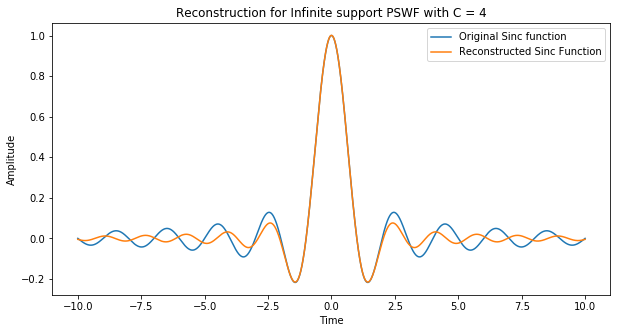

In [580]:
## Reconstruction in infinite support
sinc_org=[]
sinc_reconstr=[]
for i in range(len(J)):
    sinc_org.append(np.sinc(J[i]))
plt.plot(J, sinc_org, label= "Original Sinc function")
plt.plot(J, Y, label= "Reconstructed Sinc Function")
plt.title("Reconstruction for Infinite support PSWF with C = "+str(c))
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

In [581]:
## Energy Loss for infinite support
k=(np.sum(np.array(sinc_org)**2)-np.sum(np.array(Y)**2))/np.sum(np.array(sinc_org)**2)*100
print(k)

3.0631489973756407
